In [12]:
import pandas as pd
import sqlite3
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import norm, lognorm, expon, gamma, weibull_min

In [3]:
con = sqlite3.connect("nokia.db")
df = pd.read_sql("SELECT * FROM Makkah_5g",con)

In [4]:
coordinates = df[['Longitude', 'Latitude']]

# Perform KMeans clustering
kmeans = KMeans(n_clusters=53, random_state=42)
df['Cluster'] = kmeans.fit_predict(coordinates)

# Update the Makkah_5g table with the new cluster information
for i, row in df.iterrows():
    query = f"""
    UPDATE Makkah_5g
    SET Cluster = {row['Cluster']}
    WHERE Longitude = {row['Longitude']} AND Latitude = {row['Latitude']}
    """
    con.execute(query)

# Commit the changes and close the connection
con.commit()
con.close()


<h1>visualize rsrp for each cluster<h1>

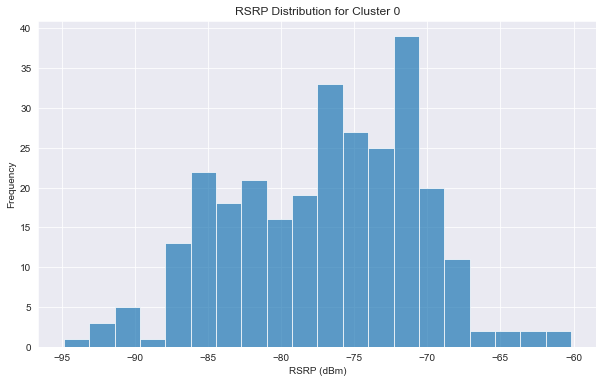

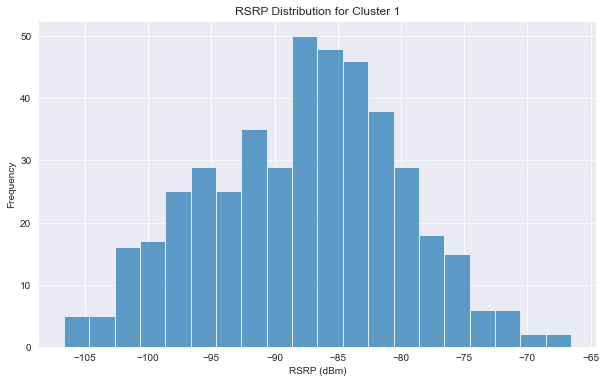

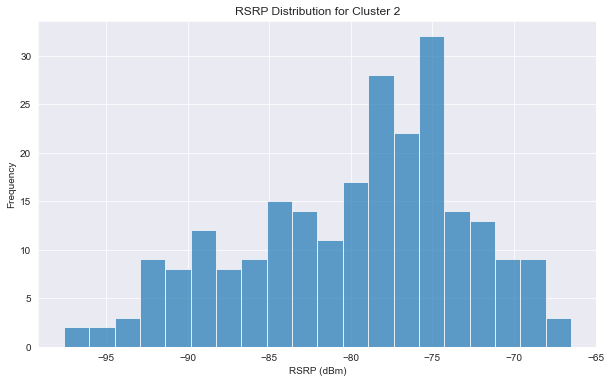

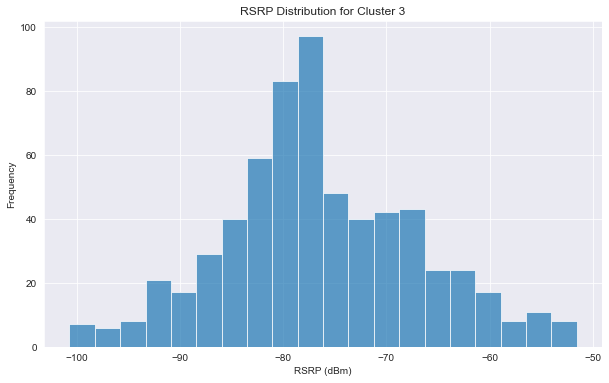

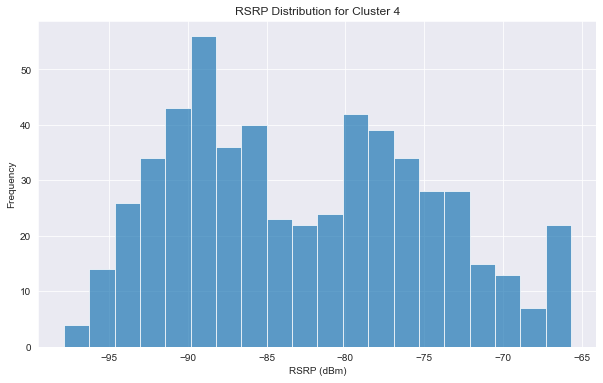

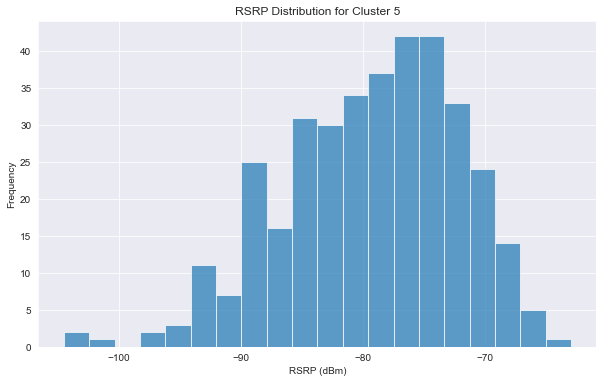

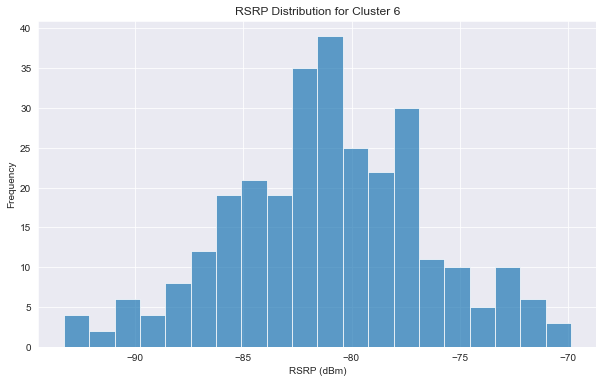

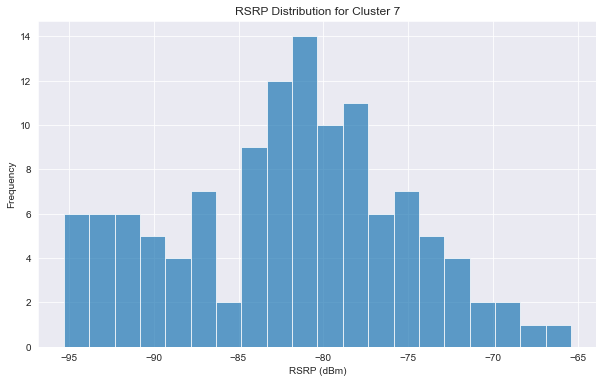

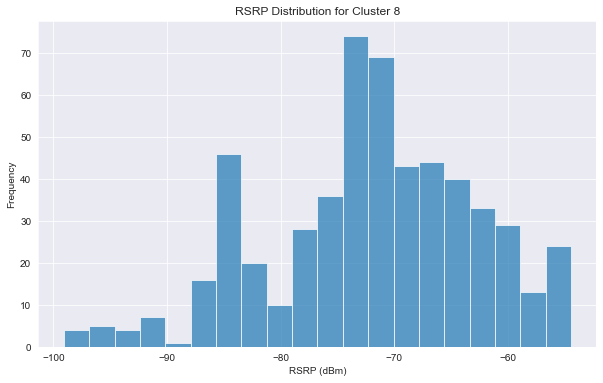

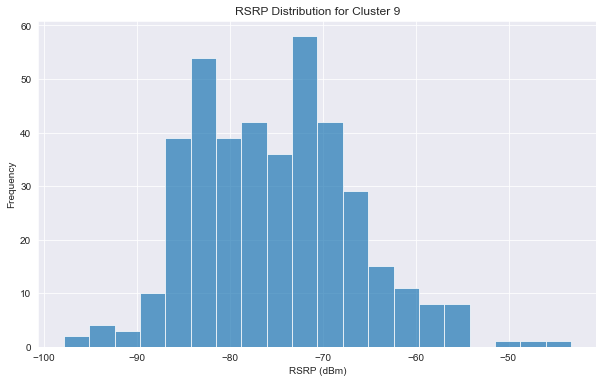

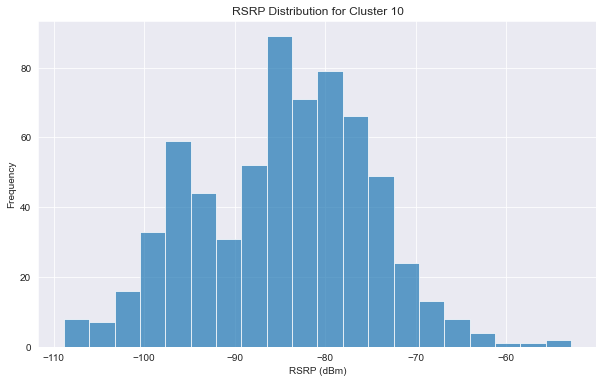

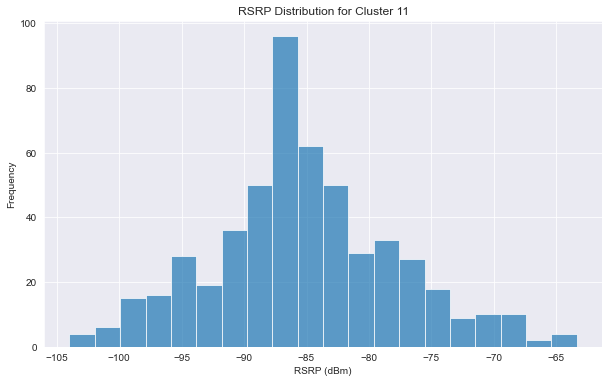

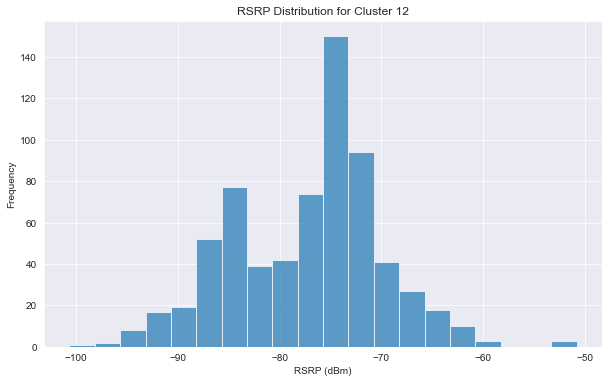

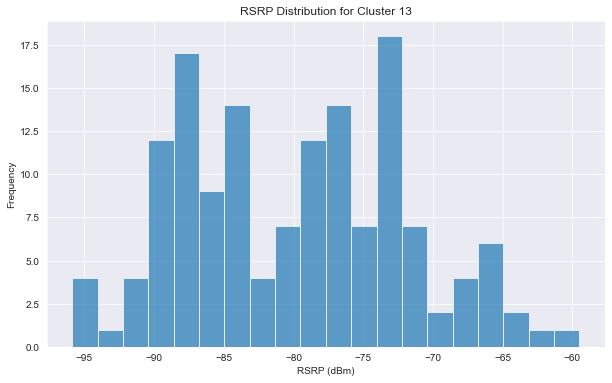

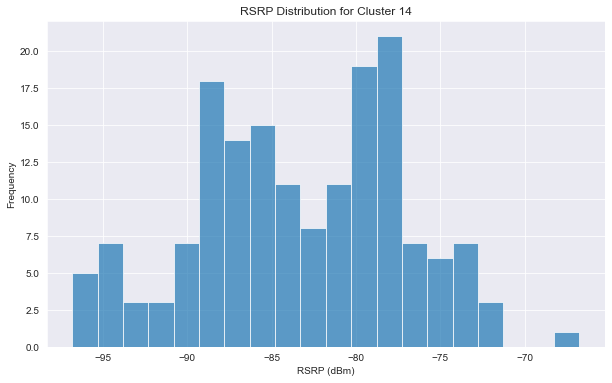

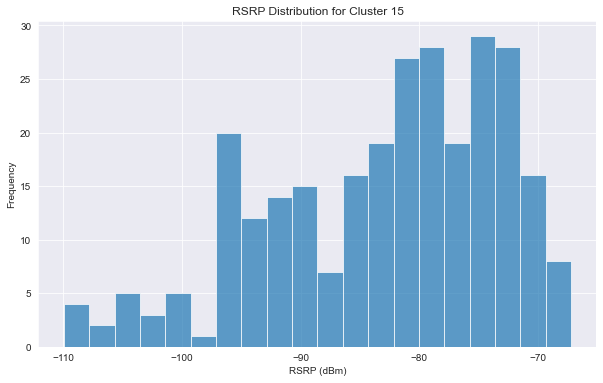

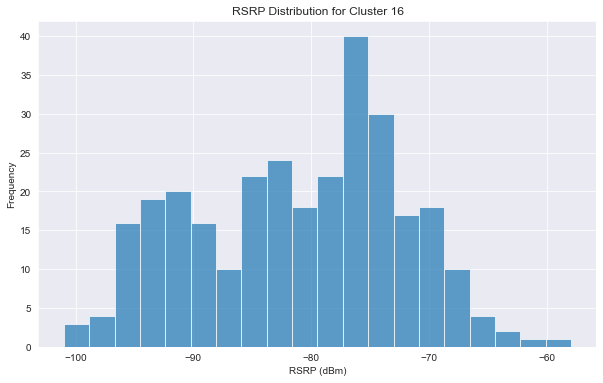

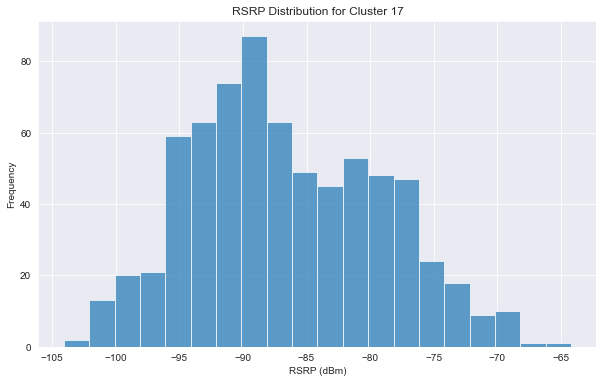

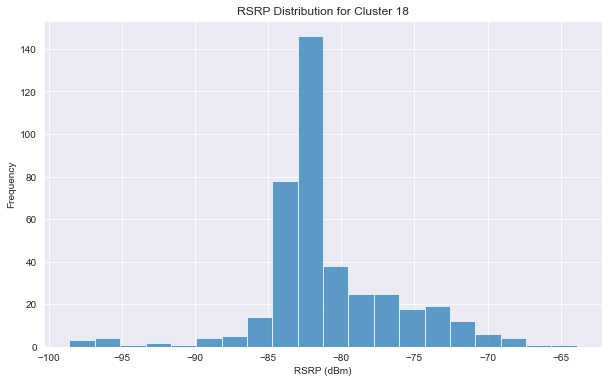

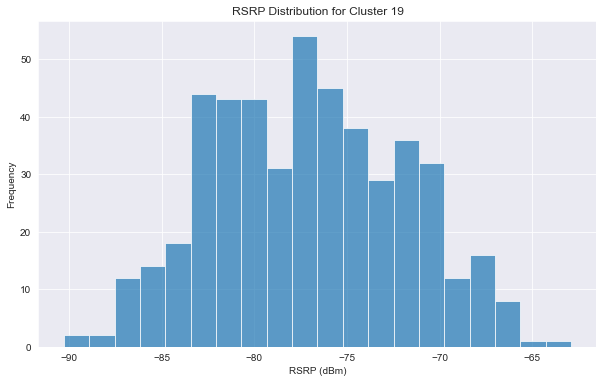

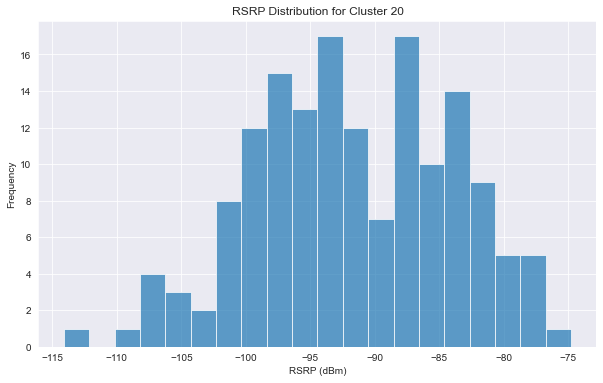

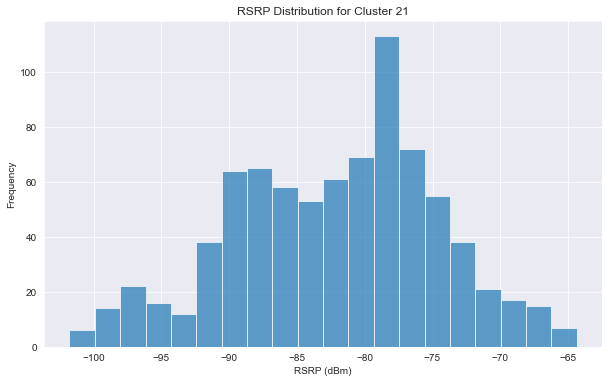

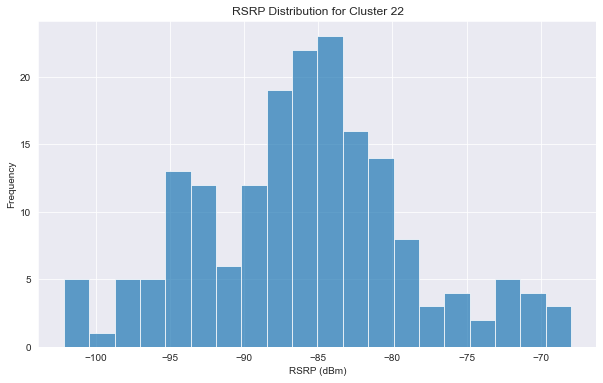

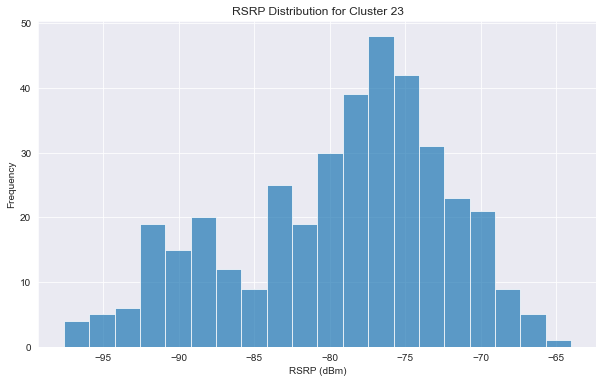

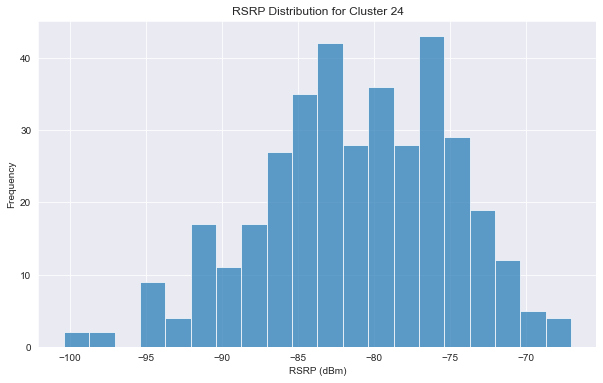

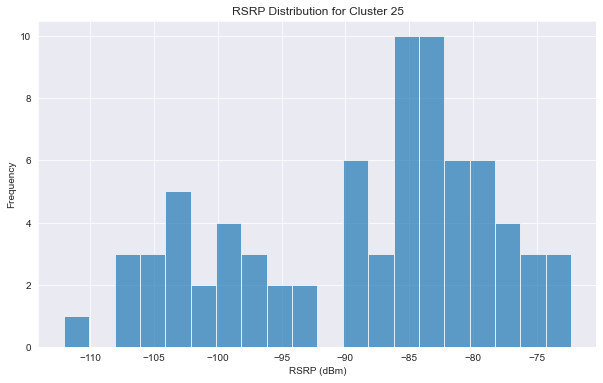

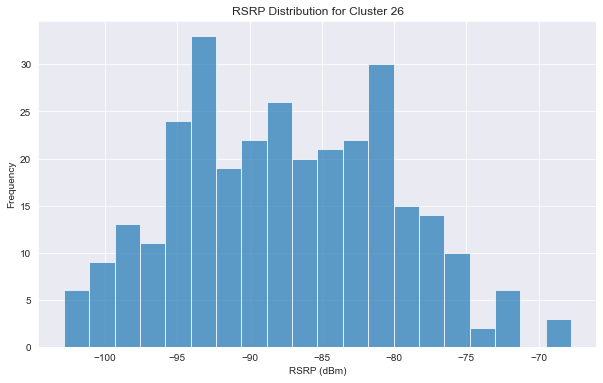

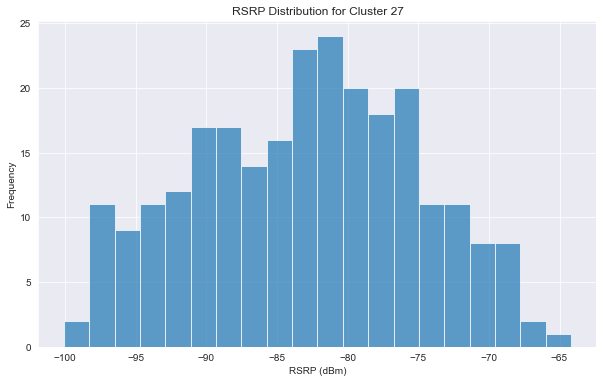

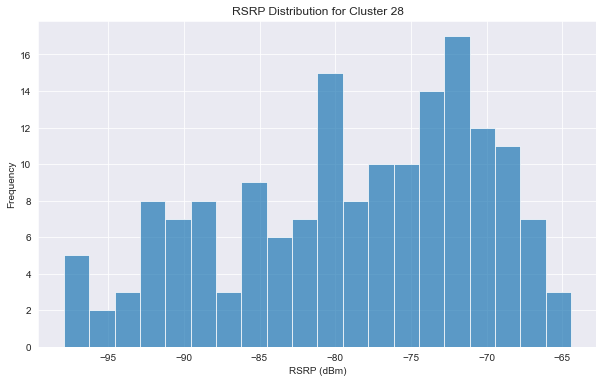

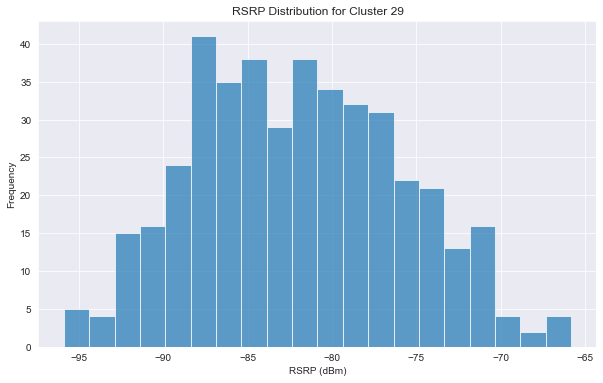

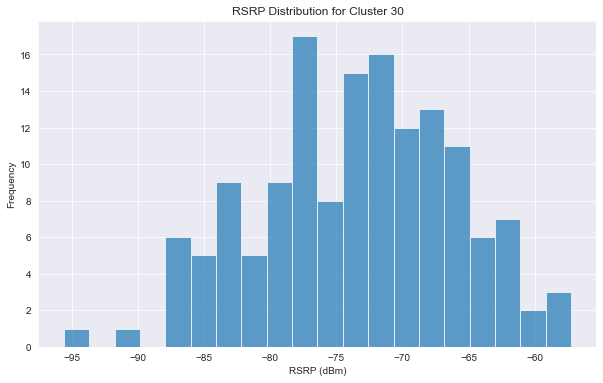

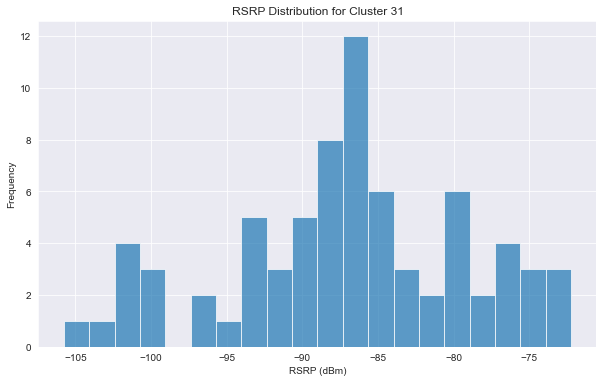

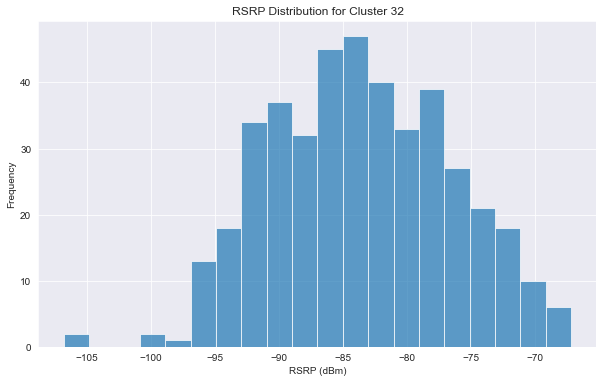

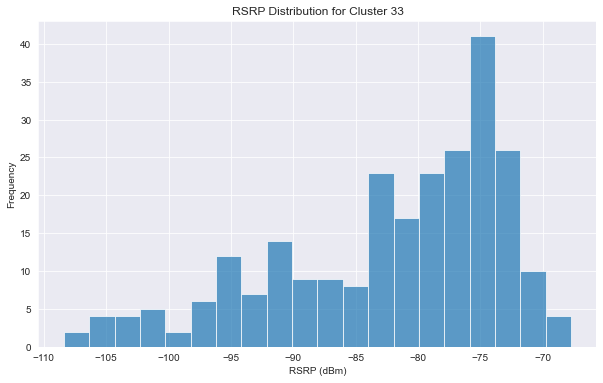

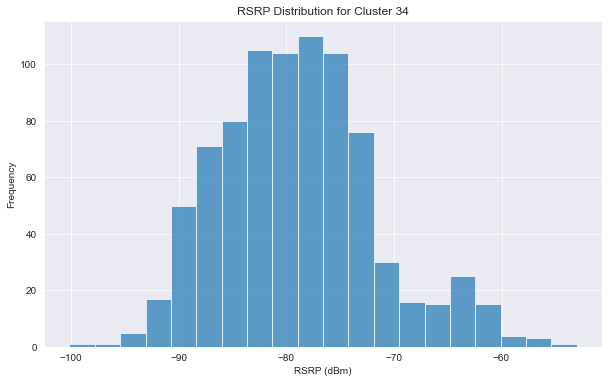

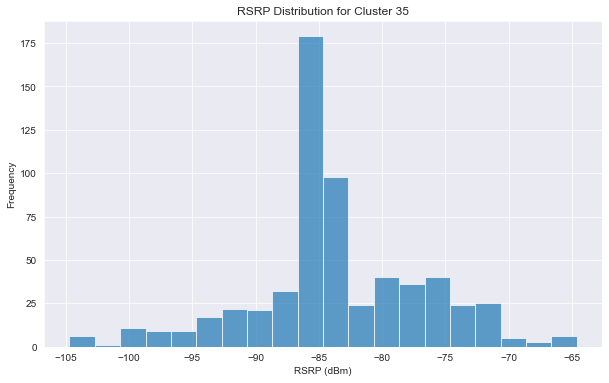

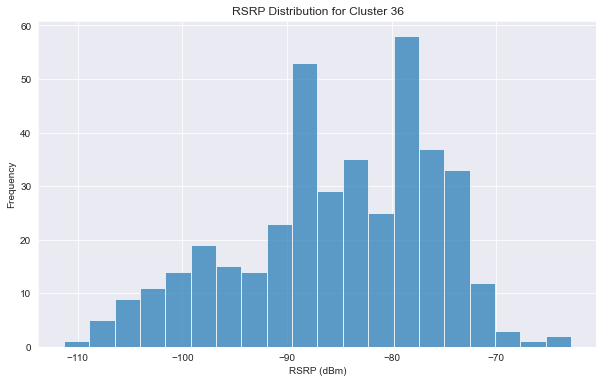

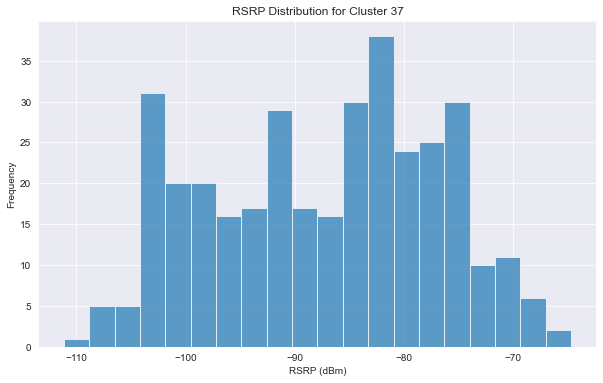

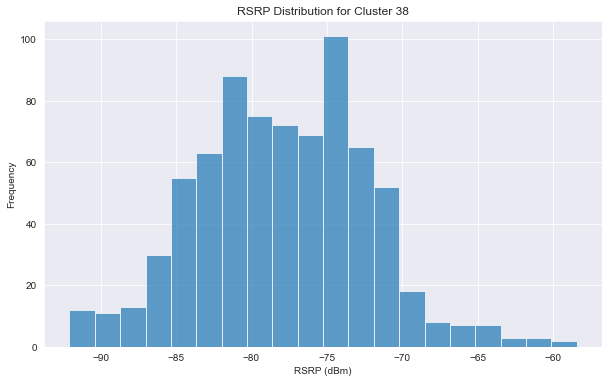

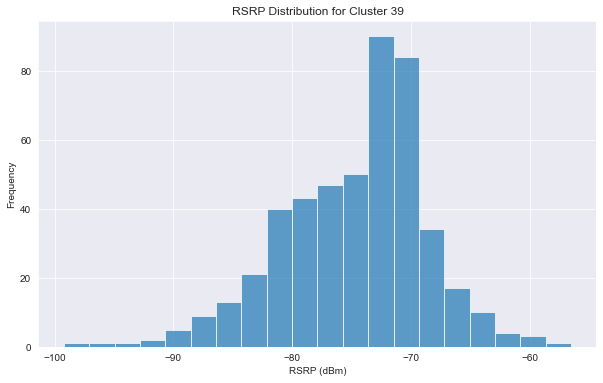

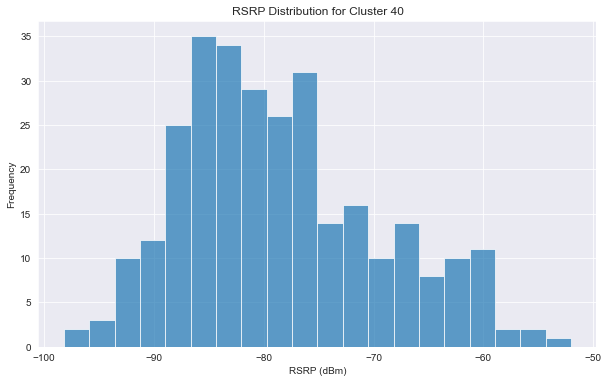

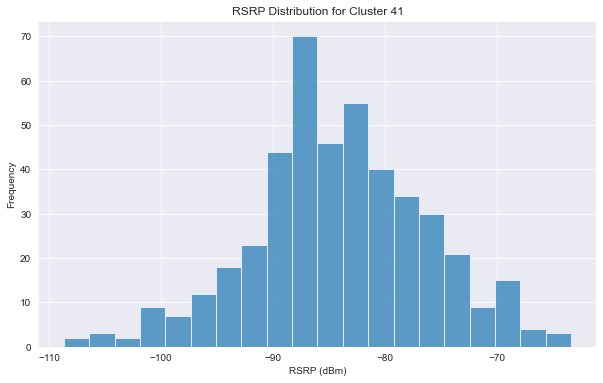

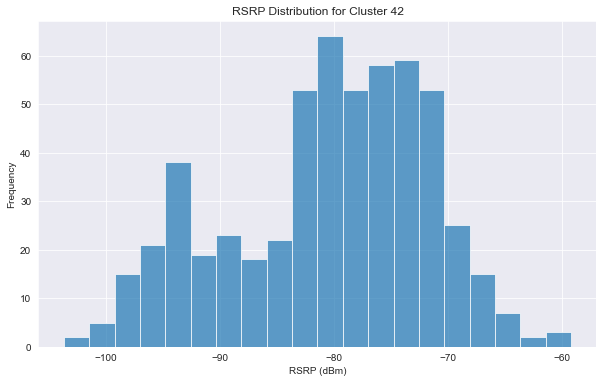

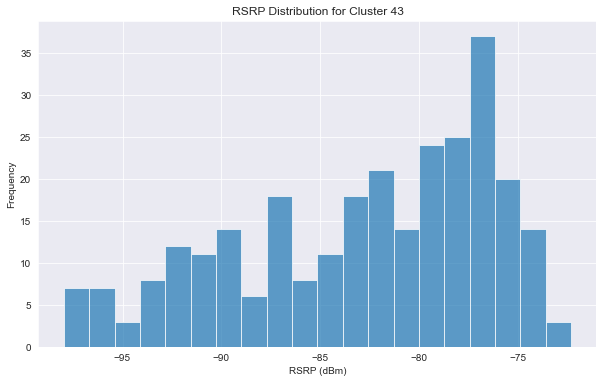

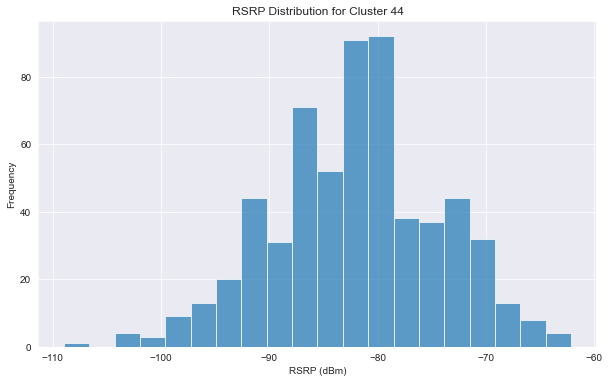

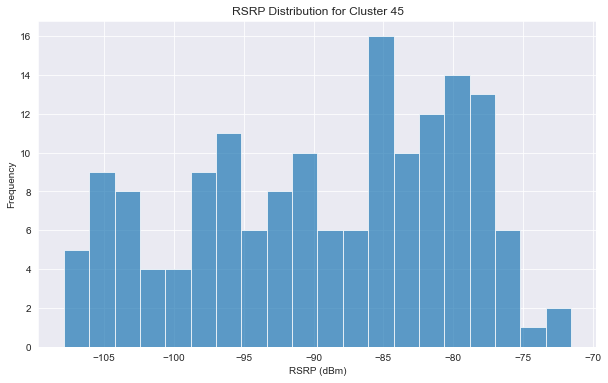

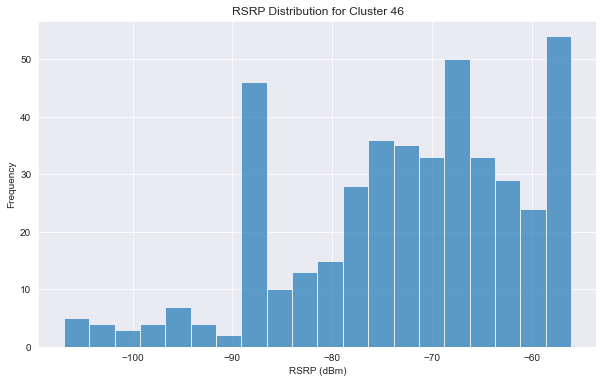

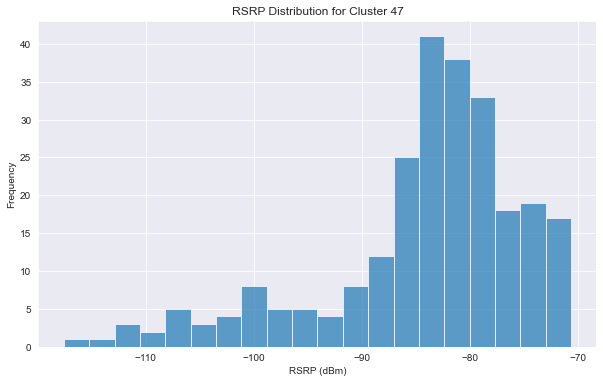

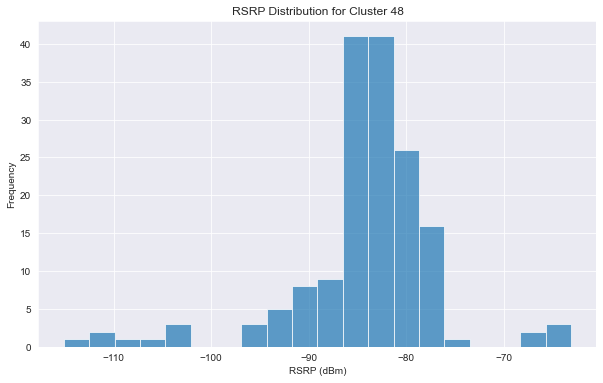

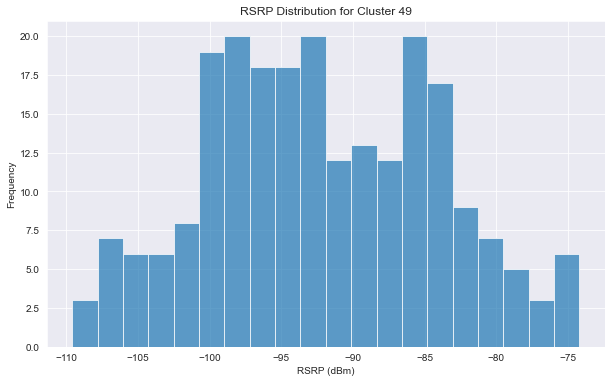

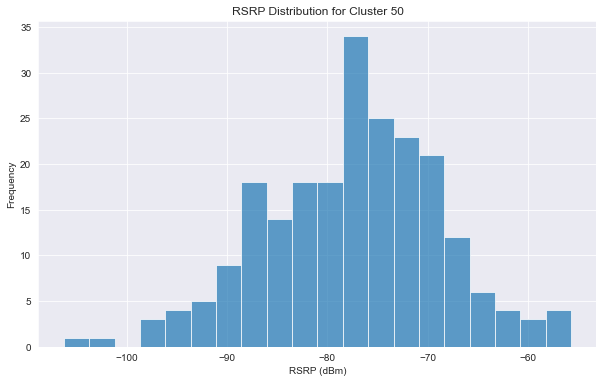

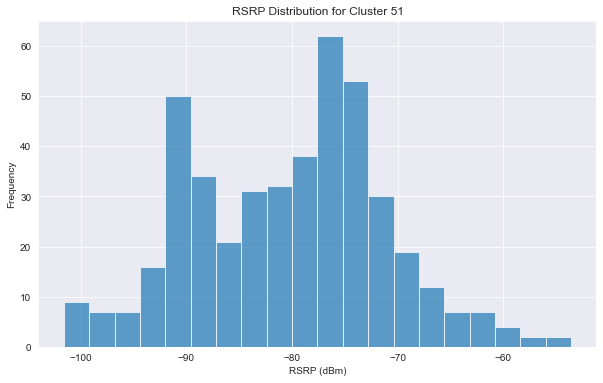

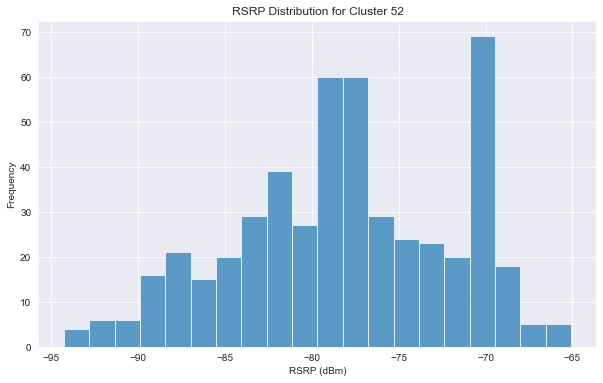

In [11]:
import matplotlib.pyplot as plt

num_clusters = df['Cluster'].nunique()
df = df.dropna(subset=['RSRP (d Bm)-Dominant RSRP (d Bm) '])

for cluster in range(num_clusters):
    # Filter data for the current cluster
    cluster_data = df[df['Cluster'] == cluster]

    # Plot the distribution of RSRP values for this cluster
    plt.figure(figsize=(10, 6))
    plt.hist(cluster_data['RSRP (d Bm)-Dominant RSRP (d Bm) '], bins=20, alpha=0.7)
    plt.title(f'RSRP Distribution for Cluster {cluster}')
    plt.xlabel('RSRP (dBm)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


<h1>Find best distribution for each cluster<h1>

/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


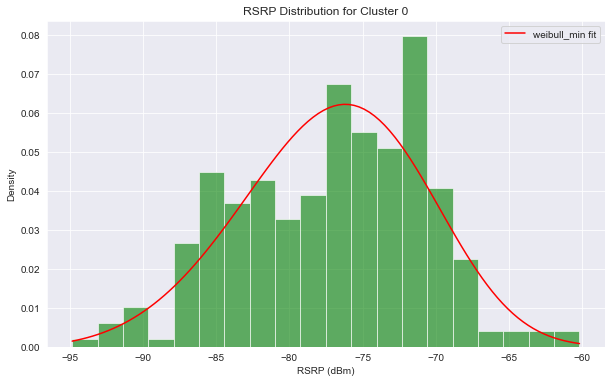

Cluster 0: Best fit distribution: weibull_min, AIC: 1842.7875358675565
Parameters: (4.4567517721172765, -101.75883075335864, 27.07089948523267)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


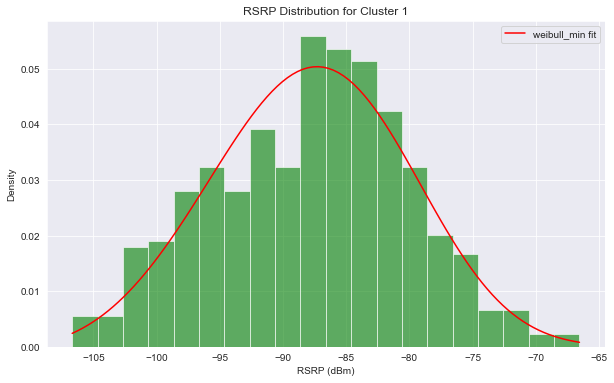

Cluster 1: Best fit distribution: weibull_min, AIC: 3088.793532041975
Parameters: (3.6821991348489576, -113.00376835692198, 28.01020548872387)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


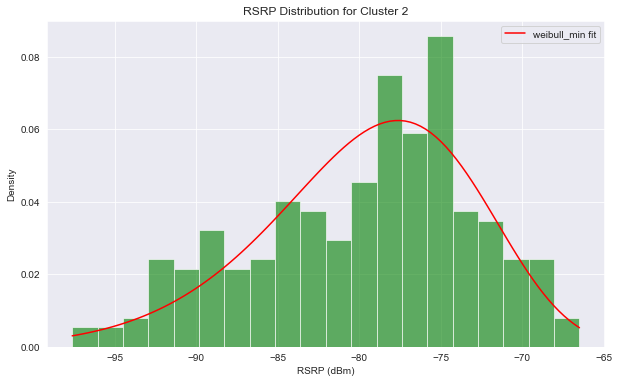

Cluster 2: Best fit distribution: weibull_min, AIC: 1587.866064993084
Parameters: (8.121612926041369, -125.05464308183377, 48.20653380213662)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


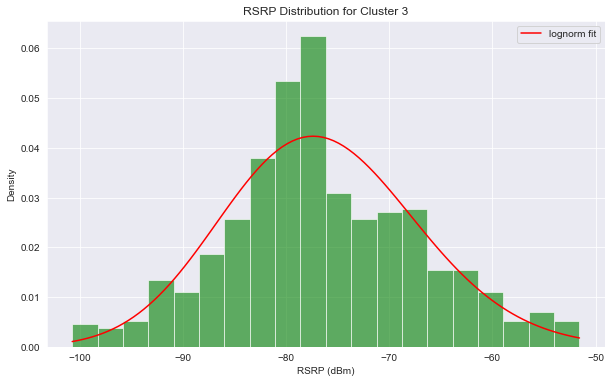

Cluster 3: Best fit distribution: lognorm, AIC: 4637.864312142418
Parameters: (0.06752578208359689, -216.6124081242067, 139.8760767891922)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


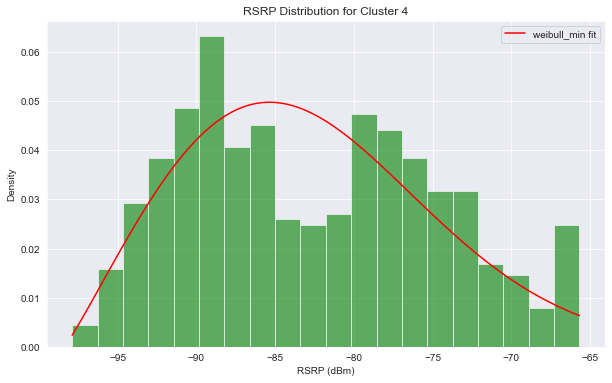

Cluster 4: Best fit distribution: weibull_min, AIC: 3799.6895355727047
Parameters: (2.0929116888695987, -98.38879683036015, 17.7707651483634)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


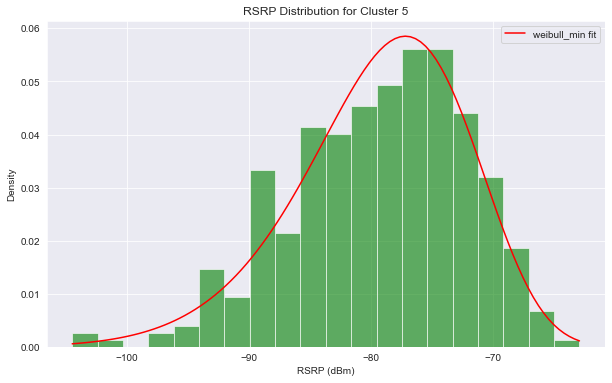

Cluster 5: Best fit distribution: weibull_min, AIC: 2422.137265172304
Parameters: (8.171998493343581, -128.121634985336, 51.759530418390526)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


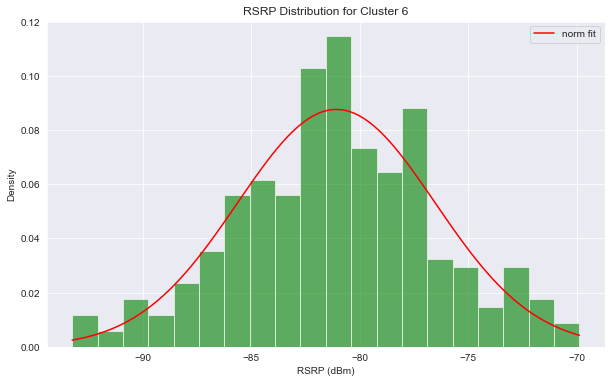

Cluster 6: Best fit distribution: norm, AIC: 1712.0413943070794
Parameters: (-81.0845704467354, 4.5532464990886865)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


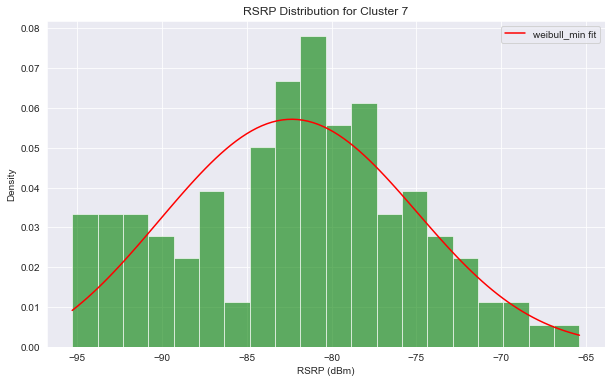

Cluster 7: Best fit distribution: weibull_min, AIC: 803.6450085157421
Parameters: (3.083995274997056, -100.91103019908053, 21.069596458486963)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


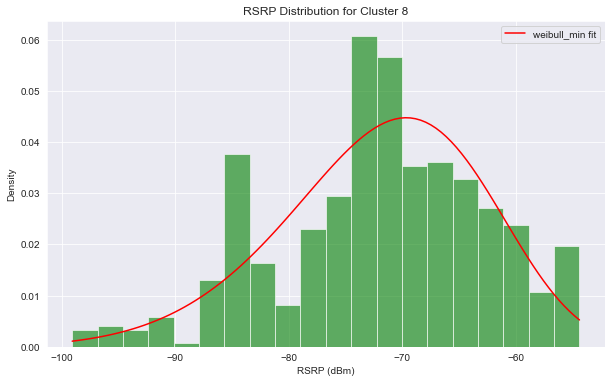

Cluster 8: Best fit distribution: weibull_min, AIC: 3947.771816592362
Parameters: (6.3123799840638615, -120.856439184733, 52.597757786323015)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


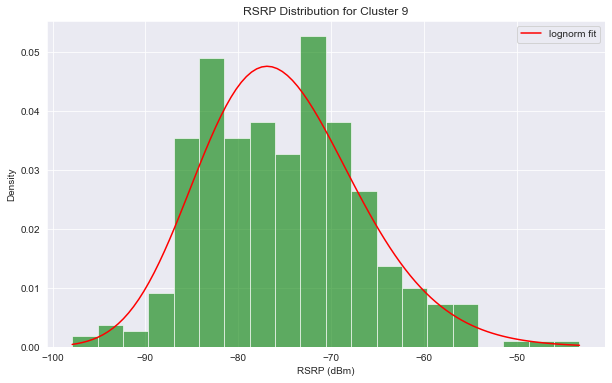

Cluster 9: Best fit distribution: lognorm, AIC: 2870.786982322307
Parameters: (0.13496671476004557, -138.45013829563112, 62.68455621343287)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


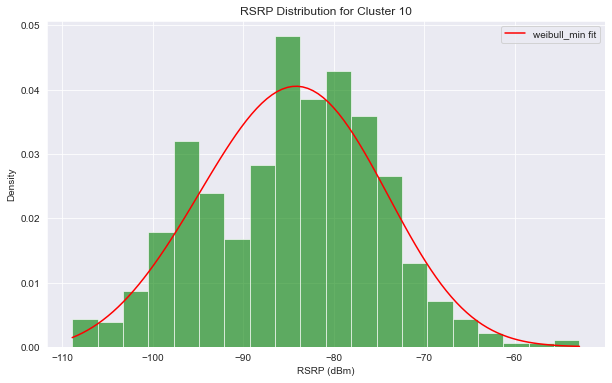

Cluster 10: Best fit distribution: weibull_min, AIC: 4828.367254209222
Parameters: (3.629180592865551, -115.59437798918992, 34.36012995992638)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


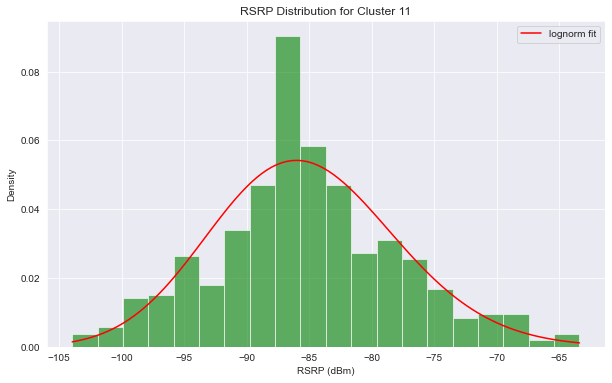

Cluster 11: Best fit distribution: lognorm, AIC: 3588.2079718445
Parameters: (0.07365396196335242, -185.72683528149548, 100.24089288875328)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


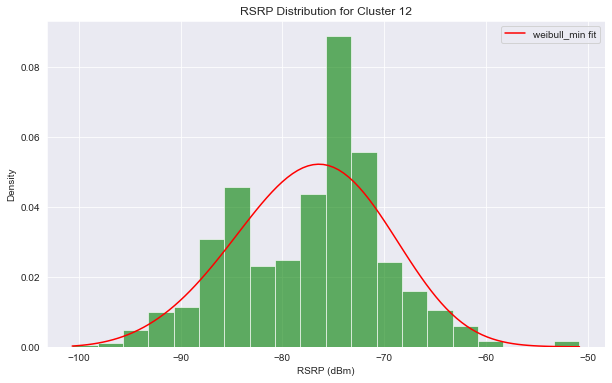

Cluster 12: Best fit distribution: weibull_min, AIC: 4634.693669644726
Parameters: (4.124937308004231, -104.44983320178346, 29.99221210709019)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


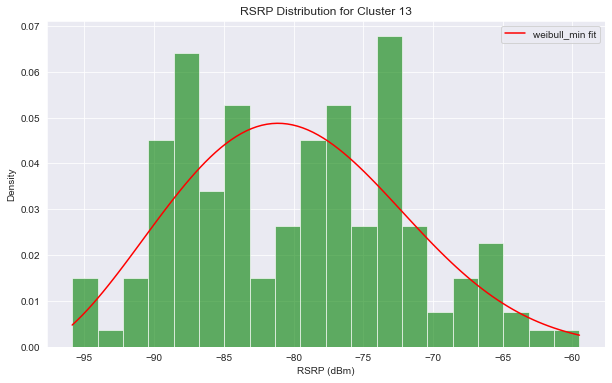

Cluster 13: Best fit distribution: weibull_min, AIC: 1018.7304568137167
Parameters: (2.562878901183704, -98.54525274382212, 21.129280240579327)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


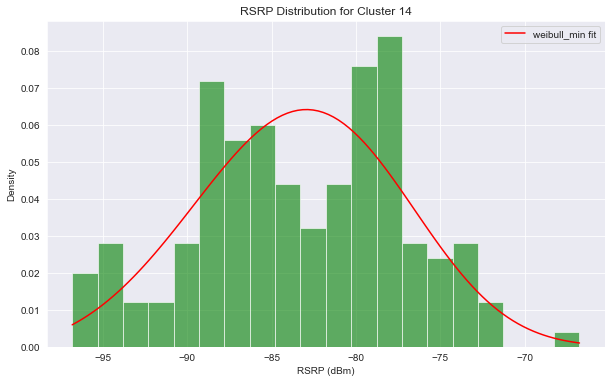

Cluster 14: Best fit distribution: weibull_min, AIC: 1073.5251186996898
Parameters: (3.7393846521623333, -103.4384037220567, 22.274980012208502)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


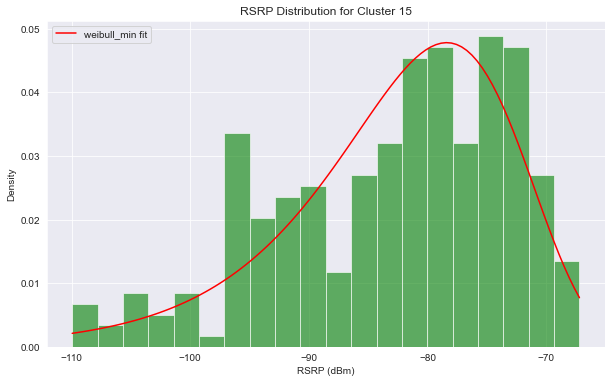

Cluster 15: Best fit distribution: weibull_min, AIC: 2024.4744451904653
Parameters: (84317584.59604383, -649096706.6219938, 649096628.2340746)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


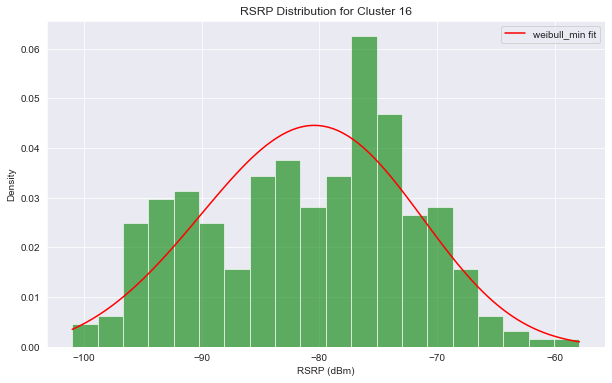

Cluster 16: Best fit distribution: weibull_min, AIC: 2136.063052085866
Parameters: (3.7304981193095745, -109.9042046962749, 32.03505462495783)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


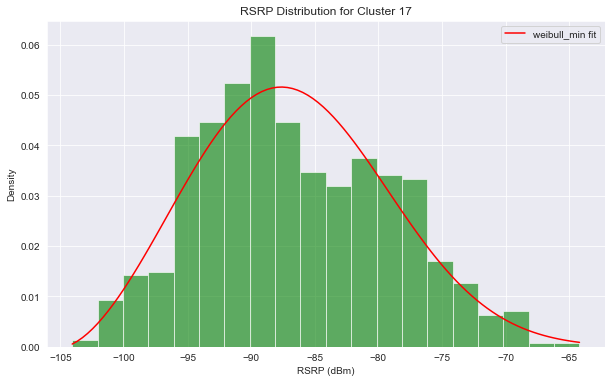

Cluster 17: Best fit distribution: weibull_min, AIC: 4821.661218041693
Parameters: (2.654802061515091, -104.83493067777577, 20.54284474670969)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


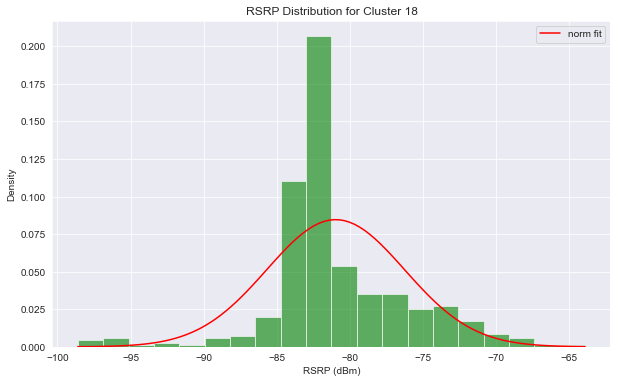

Cluster 18: Best fit distribution: norm, AIC: 2421.2789807706063
Parameters: (-80.9684275184275, 4.714730065569371)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


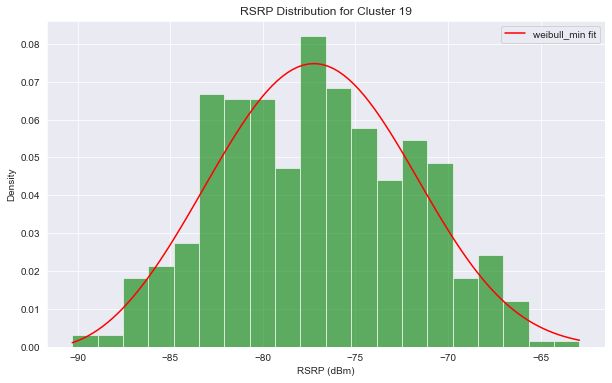

Cluster 19: Best fit distribution: weibull_min, AIC: 2936.6435629331318
Parameters: (3.1457358708814604, -91.75096761513399, 16.385678847228576)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


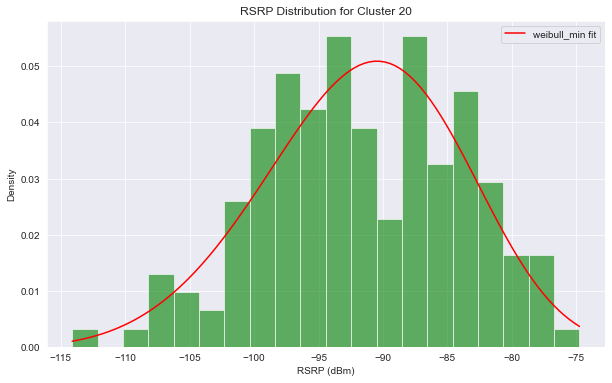

Cluster 20: Best fit distribution: weibull_min, AIC: 1084.8954495605822
Parameters: (4.620735476299966, -122.95065443793852, 34.23913017034616)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


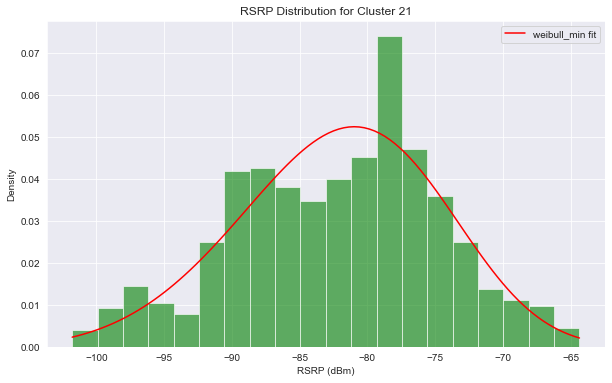

Cluster 21: Best fit distribution: weibull_min, AIC: 5607.656661536002
Parameters: (4.6146796778951735, -112.48341413275324, 33.21523644202491)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


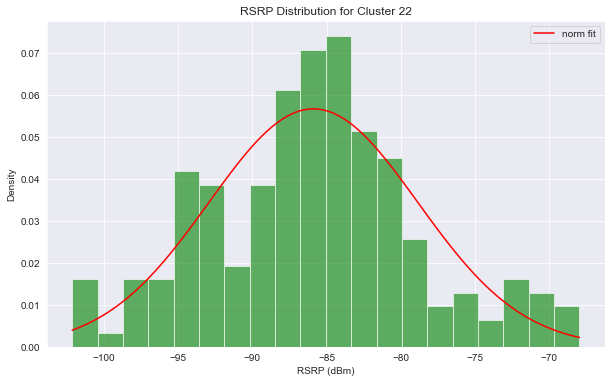

Cluster 22: Best fit distribution: norm, AIC: 1231.1342980976306
Parameters: (-85.89373626373626, 7.044939364942604)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


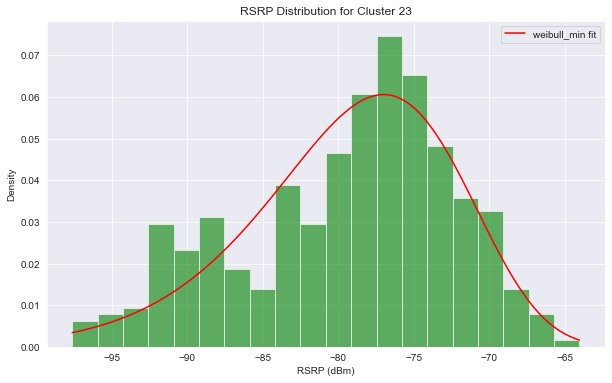

Cluster 23: Best fit distribution: weibull_min, AIC: 2561.344273109251
Parameters: (9.881262091449841, -136.6440282019513, 60.30206171407916)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


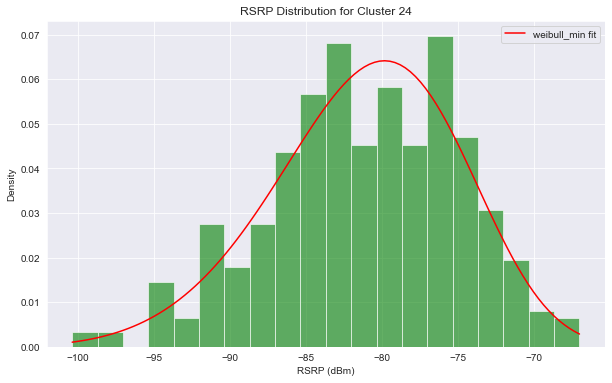

Cluster 24: Best fit distribution: weibull_min, AIC: 2402.9265995008946
Parameters: (5.43958397570198, -110.4459319028143, 31.756903176841234)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


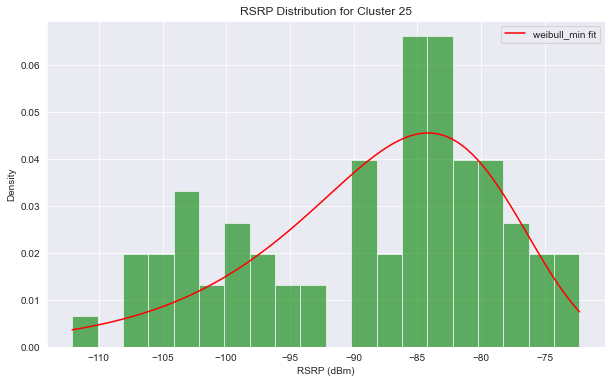

Cluster 25: Best fit distribution: weibull_min, AIC: 563.685427597333
Parameters: (76.30634551189266, -700.74512969859, 616.6820334155493)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


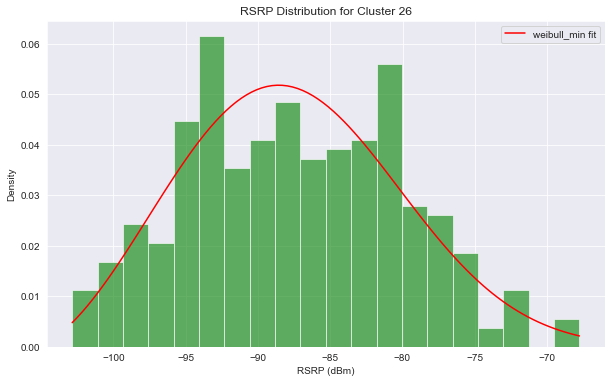

Cluster 26: Best fit distribution: weibull_min, AIC: 2093.457392851479
Parameters: (2.639119215054286, -105.58036509434336, 20.380719883367597)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


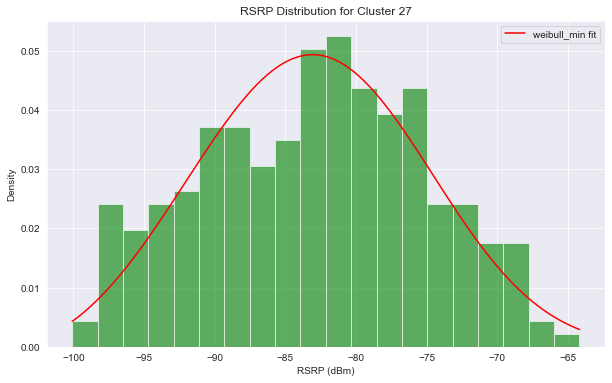

Cluster 27: Best fit distribution: weibull_min, AIC: 1776.979381804957
Parameters: (3.2026353187900867, -105.52941563672329, 25.242601341348937)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


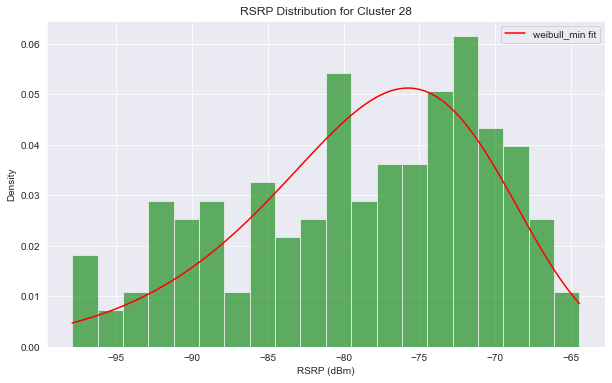

Cluster 28: Best fit distribution: weibull_min, AIC: 1166.504295813681
Parameters: (12.399232937539992, -164.44137099287548, 89.29009828521286)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


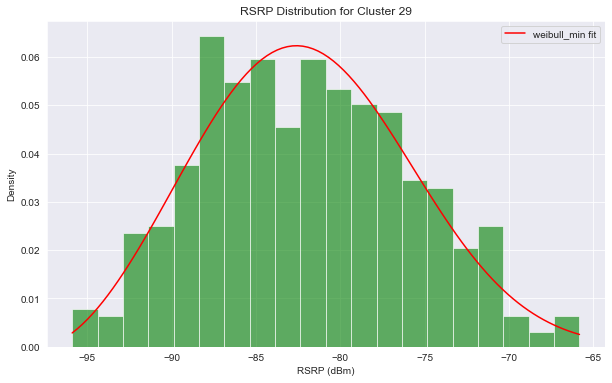

Cluster 29: Best fit distribution: weibull_min, AIC: 2739.1415970198486
Parameters: (2.809647323445565, -97.85171309770712, 17.834227802953187)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


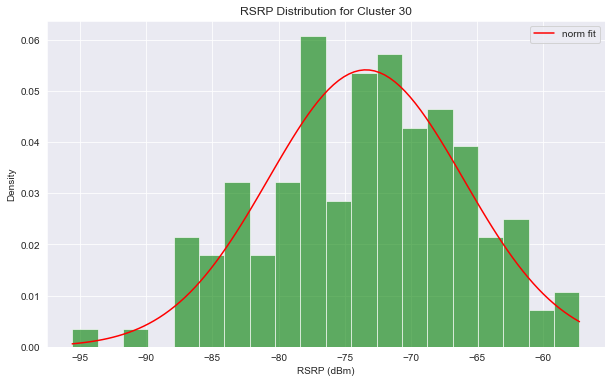

Cluster 30: Best fit distribution: norm, AIC: 1001.5228701658652
Parameters: (-73.39657534246575, 7.368658586717882)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


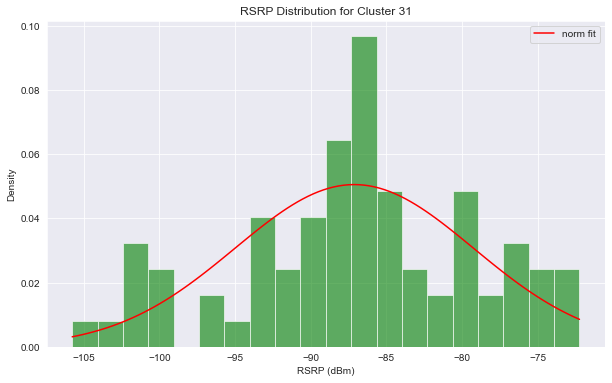

Cluster 31: Best fit distribution: norm, AIC: 519.8920867236816
Parameters: (-87.11932432432434, 7.8996528030241455)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


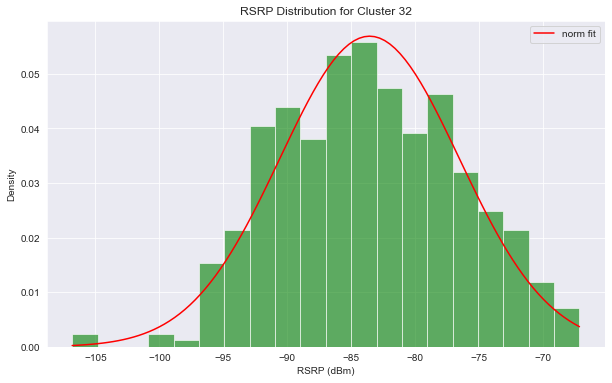

Cluster 32: Best fit distribution: norm, AIC: 2865.293283037806
Parameters: (-83.5814588235294, 7.009657622843)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


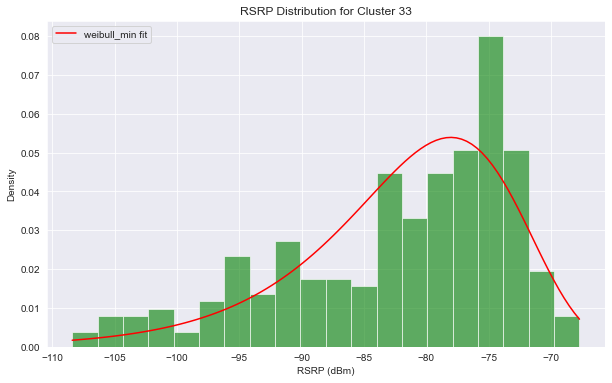

Cluster 33: Best fit distribution: weibull_min, AIC: 1785.0737579527722
Parameters: (71722278.91546091, -489310103.9151251, 489310025.8750061)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


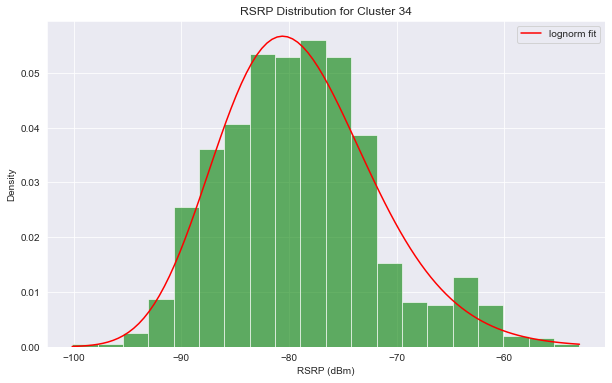

Cluster 34: Best fit distribution: lognorm, AIC: 5640.224846917422
Parameters: (0.15372755781095254, -125.8418560874786, 46.31762271501565)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


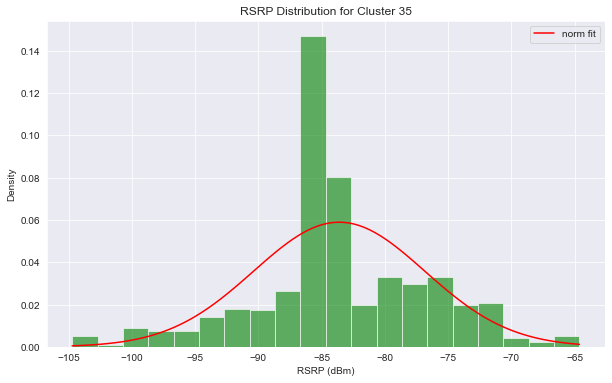

Cluster 35: Best fit distribution: norm, AIC: 4054.8123306272087
Parameters: (-83.61427631578947, 6.7687850307178925)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


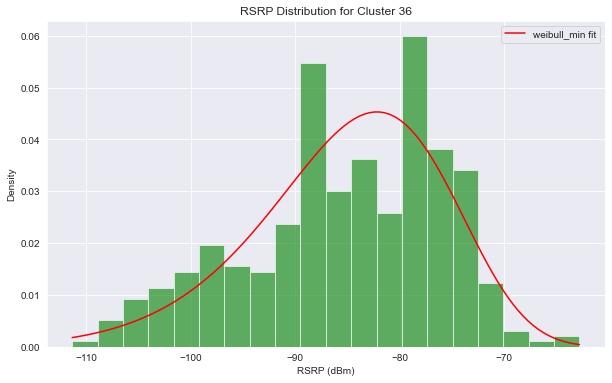

Cluster 36: Best fit distribution: weibull_min, AIC: 2895.802091550856
Parameters: (8.885891023000646, -153.83347930811647, 72.6039088245407)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


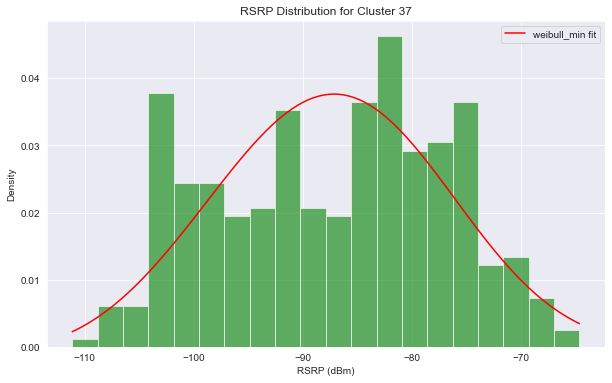

Cluster 37: Best fit distribution: weibull_min, AIC: 2653.1095513574696
Parameters: (3.348905155117511, -118.08190983065802, 34.39356859493003)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


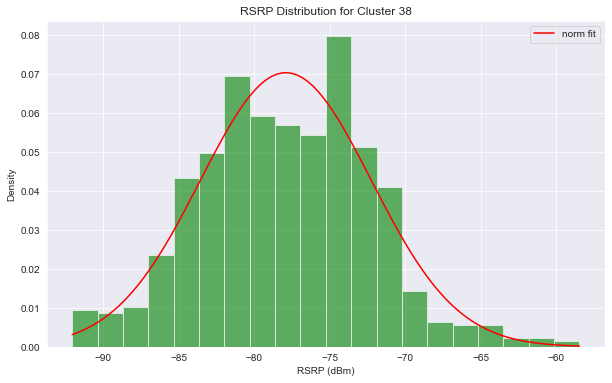

Cluster 38: Best fit distribution: norm, AIC: 4760.2668601546375
Parameters: (-77.90757294429707, 5.669407322455779)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


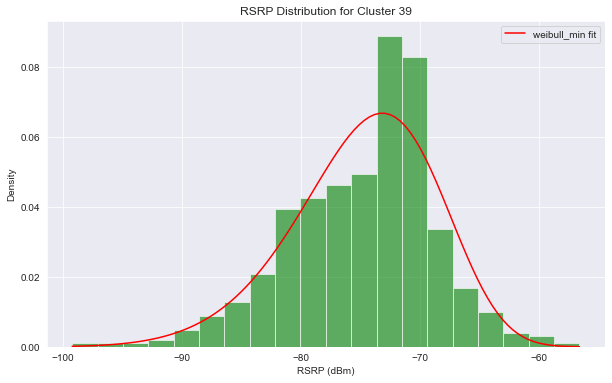

Cluster 39: Best fit distribution: weibull_min, AIC: 3057.1283607217492
Parameters: (6.833759733083541, -110.39589035638369, 38.12427429602039)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


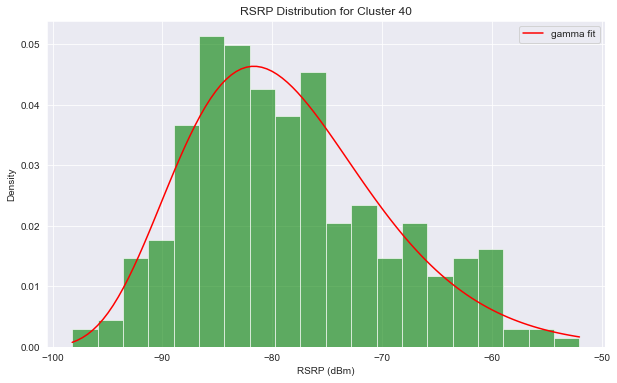

Cluster 40: Best fit distribution: gamma, AIC: 2119.749237492006
Parameters: (8.045988283600735, -104.23516163296833, 3.2021901576843765)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


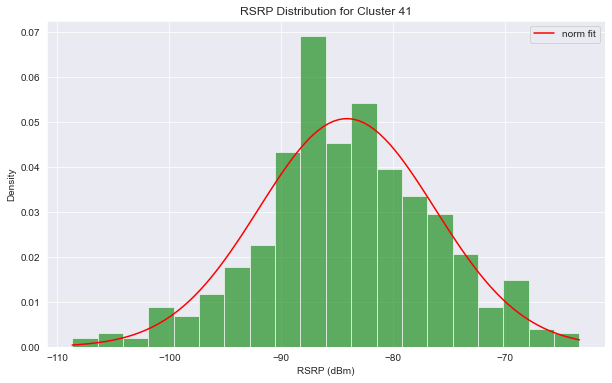

Cluster 41: Best fit distribution: norm, AIC: 3115.022024771608
Parameters: (-84.15673378076062, 7.853441747007889)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


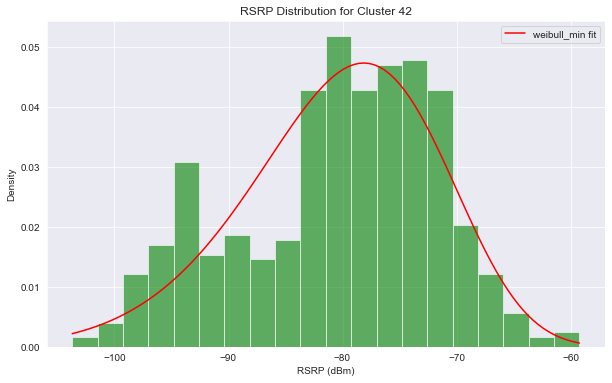

Cluster 42: Best fit distribution: weibull_min, AIC: 3960.0885262079423
Parameters: (6.738232076481511, -129.8421591425187, 52.951965387153194)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


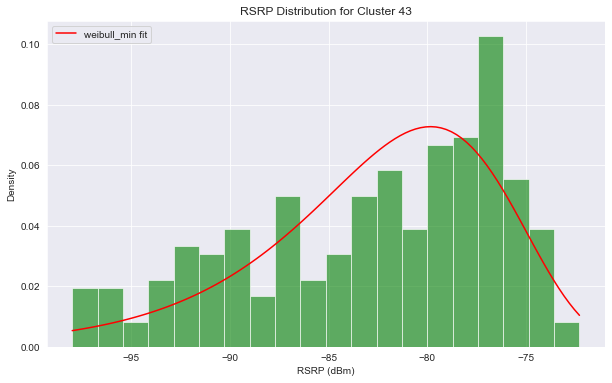

Cluster 43: Best fit distribution: weibull_min, AIC: 1814.4601883722958
Parameters: (7843202.407830992, -39669944.96838034, 39669865.12429051)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


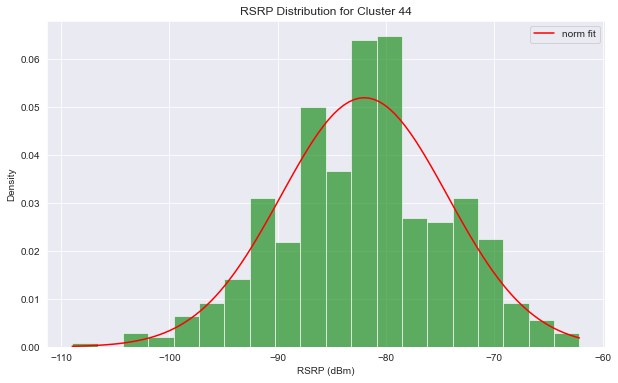

Cluster 44: Best fit distribution: norm, AIC: 4202.632208775671
Parameters: (-82.00948929159802, 7.687320991251615)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


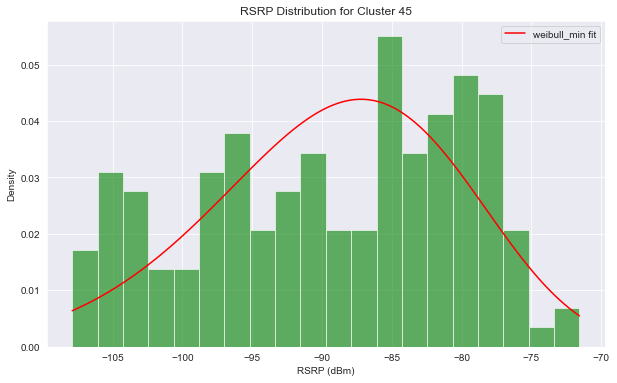

Cluster 45: Best fit distribution: weibull_min, AIC: 1169.2488280765099
Parameters: (5.76197737508359, -134.72149288334265, 49.110968621343744)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


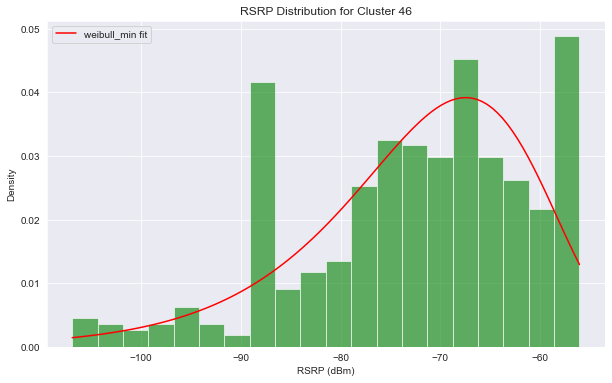

Cluster 46: Best fit distribution: weibull_min, AIC: 3324.6896111614587
Parameters: (62.35228266268563, -652.8382742236312, 585.5286649556085)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


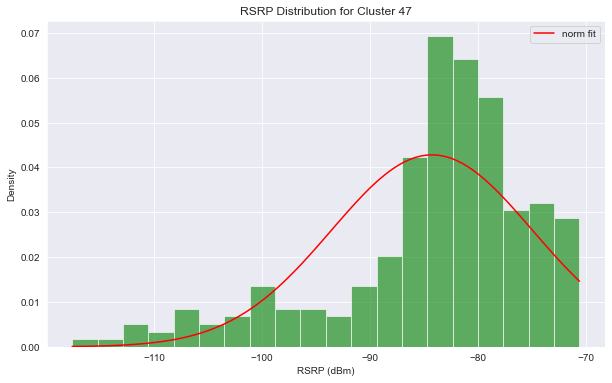

Cluster 47: Best fit distribution: norm, AIC: 1844.2161305642235
Parameters: (-84.27119047619048, 9.321130765175253)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


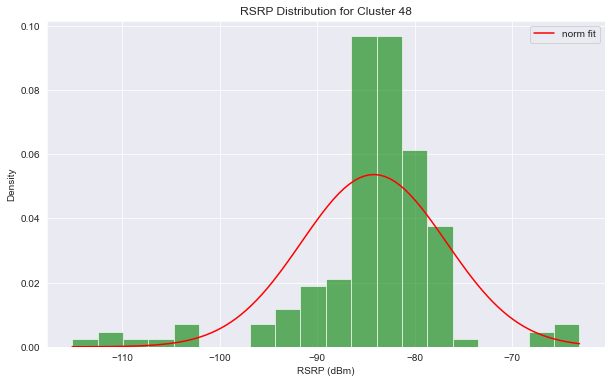

Cluster 48: Best fit distribution: norm, AIC: 1120.5699079241635
Parameters: (-84.20122699386502, 7.434434620493201)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


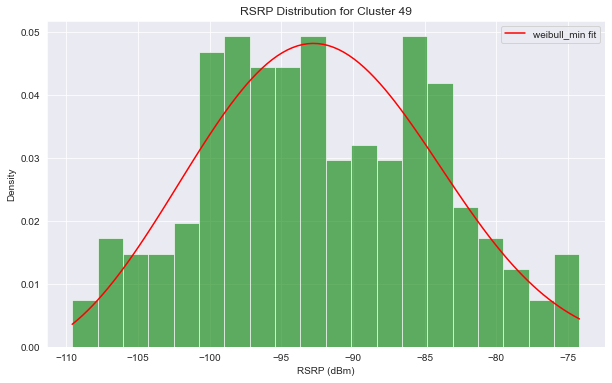

Cluster 49: Best fit distribution: weibull_min, AIC: 1602.4529841054216
Parameters: (2.9151155396462243, -113.36763188682357, 23.79430748602537)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


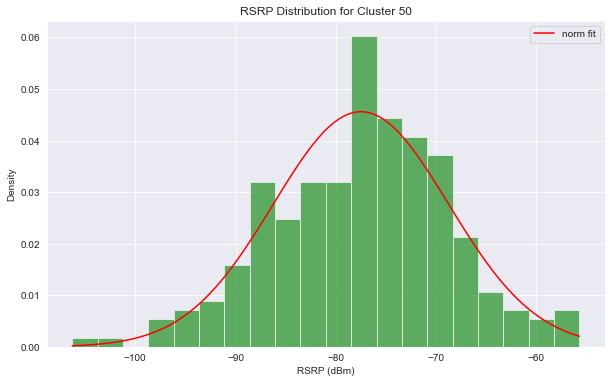

Cluster 50: Best fit distribution: norm, AIC: 1604.1582018200925
Parameters: (-77.48291479820627, 8.748306384559347)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


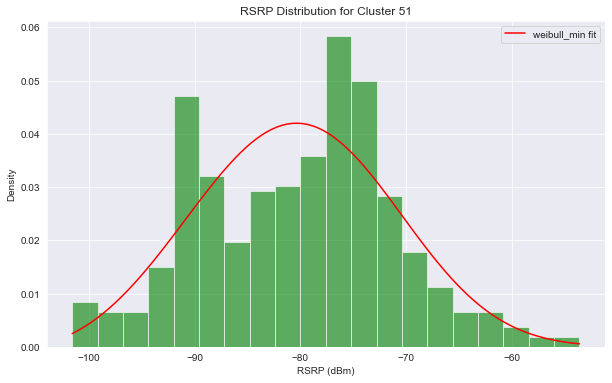

Cluster 51: Best fit distribution: weibull_min, AIC: 3221.1021501096525
Parameters: (3.254503561340135, -107.23220415897683, 30.067073971768117)


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


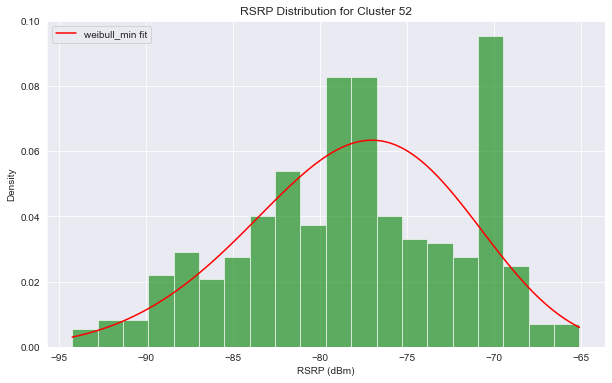

Cluster 52: Best fit distribution: weibull_min, AIC: 3226.449474669862
Parameters: (4.769165941941117, -103.98151298695132, 28.327193090347908)


In [13]:
num_clusters = df['Cluster'].nunique()
df = df.dropna(subset=['RSRP (d Bm)-Dominant RSRP (d Bm) '])

# Function to calculate AIC
def calculate_aic(log_likelihood, num_params):
    return 2 * num_params - 2 * log_likelihood

# List of distributions to fit
distributions = [norm, lognorm, expon, gamma, weibull_min]

for cluster in range(num_clusters):
    # Filter data for the current cluster
    cluster_data = df[df['Cluster'] == cluster]['RSRP (d Bm)-Dominant RSRP (d Bm) ']

    # Initialize variables to track the best distribution
    best_distribution = None
    best_aic = np.inf
    best_params = None

    # Fit each distribution to the cluster data
    for distribution in distributions:
        # Fit the distribution to the data
        params = distribution.fit(cluster_data)

        # Calculate the log-likelihood and AIC
        log_likelihood = np.sum(distribution.logpdf(cluster_data, *params))
        num_params = len(params)
        aic = calculate_aic(log_likelihood, num_params)

        # Update the best distribution if the current one has a lower AIC
        if aic < best_aic:
            best_aic = aic
            best_distribution = distribution
            best_params = params

    # Plot the histogram and the best-fitting distribution
    plt.figure(figsize=(10, 6))
    plt.hist(cluster_data, bins=20, density=True, alpha=0.6, color='g')

    # Plot the best fit distribution
    x = np.linspace(min(cluster_data), max(cluster_data), 100)
    pdf_fitted = best_distribution.pdf(x, *best_params)
    plt.plot(x, pdf_fitted, 'r-', label=f'{best_distribution.name} fit')

    plt.title(f'RSRP Distribution for Cluster {cluster}')
    plt.xlabel('RSRP (dBm)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'Cluster {cluster}: Best fit distribution: {best_distribution.name}, AIC: {best_aic}')
    print(f'Parameters: {best_params}')